## Check observables given a results file from a `TRSL` simulation

We are checking:
1. Protein production rate
2. Ribosome speed
3. Ribosome density (TODO: compare with Siwiak)
4. Number of free ribosomes

In [58]:
import cPickle as pkl
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
from statsmodels.nonparametric.smoothers_lowess import lowess

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [59]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path,'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)

The following pickle file contains the simulation results:

In [60]:
filepath = "../results/full transcriptome and exome, no decay, specific best estimate initiation rates according to Plotkin_20150924_1940_1800s.p"

Make file readable by `ipython` in case it was created by `pypy`:

In [61]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")

In [62]:
results = pkl.load(open(filepath))

### 1. Protein production rate

In [63]:
protnames = results['timecourses'].keys()
blacklist = ['ribos._bound', 'ribos._free', 'tRNA_free', 'tRNA_bound', 'ATP', 'GTP', 'AMP', 'GDP', 'protein']
for fragment in blacklist:
    protnames = [name for name in protnames if fragment not in name]

Plot some randomly selected timecourses:

In [67]:
size = 5
protnames_plot = np.array(random.sample(protnames, size*size))
protnames_plot.shape = (size, size)

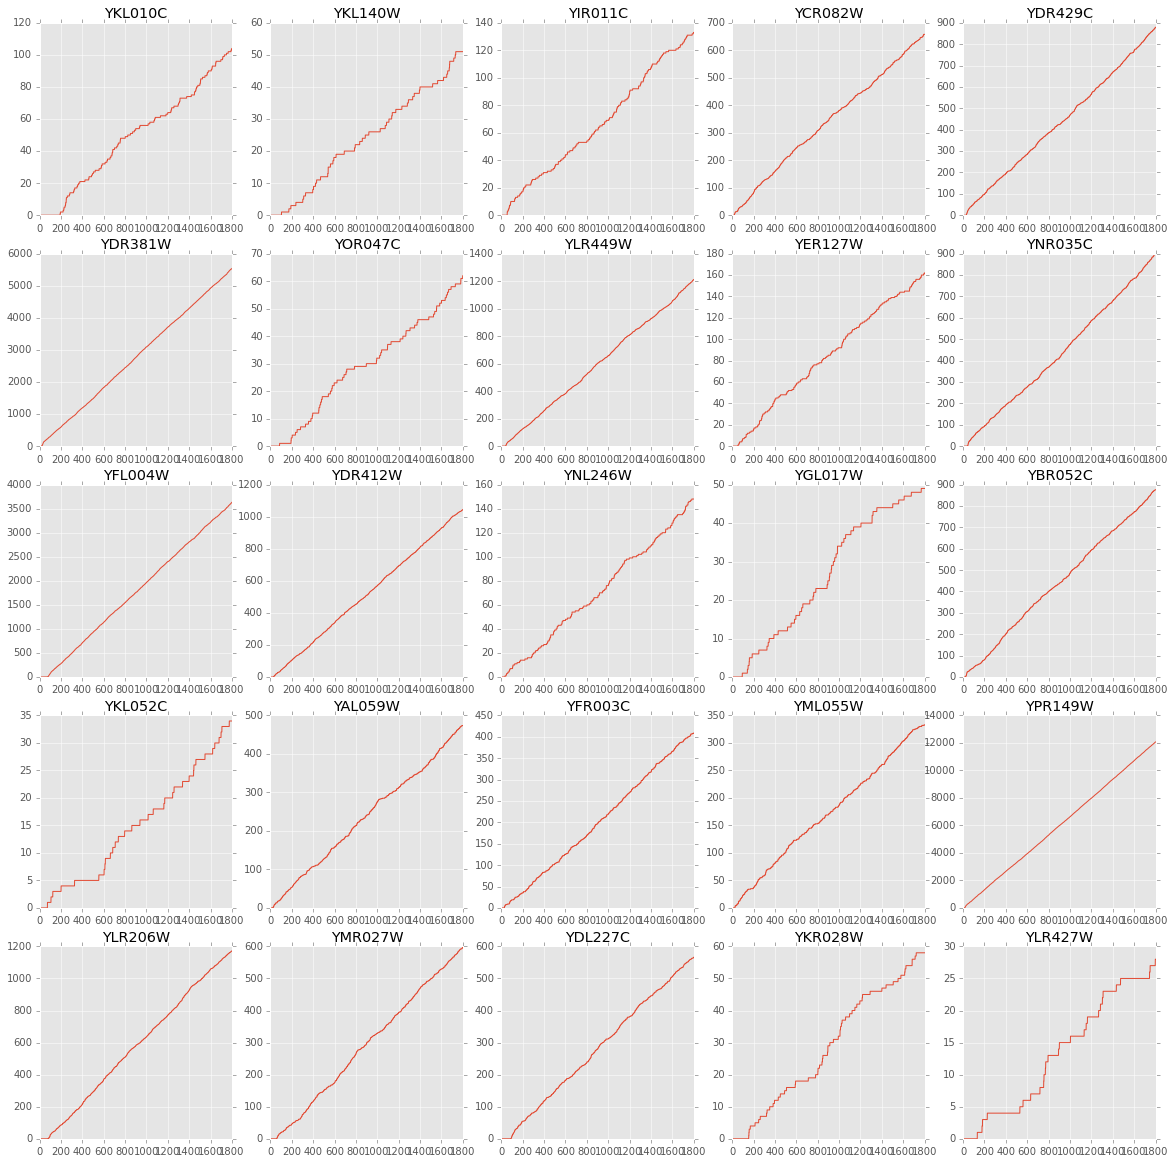

In [71]:
fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        xseries = results['timerange']
        yseries = results['timecourses'][protnames_plot[i][j]]
        # oddly, sometimes the simulation sometimes 'loses' one data point
        length = min(len(xseries), len(yseries))
        ax[i, j].plot(xseries[:length], yseries[:length])
        ax[i, j].set_title(protnames_plot[i][j])

For each protein, calculate speed of translation (TODO: start and stop should be automatic):

In [88]:
prot_speeds = {}

for prot in protnames:
    start, stop = 599, len(results['timecourses'][prot]) - 1  # to exclude the "burn in" phase
    prot_speeds[prot] = (results['timecourses'][prot][stop] - results['timecourses'][prot][start]) / (1.0 * results['timerange'][stop] - results['timerange'][start])
    if prot_speeds[prot] > 100: 
        print prot, prot_speeds[prot]

YKL060C 185.961016949
YAL038W 305.947457627
YLR109W 107.541242938
YCR012W 176.588700565
YPL131W 131.136158192
YLR110C 105.073024662
YLR340W 127.271751413
YLR044C 914.837288136
YOL086C 134.747457627
YKL152C 112.137853107
YOL039W 101.260487584
YOL040C 215.494223001


In [89]:
pd.Series(prot_speeds.values()).describe()

count    2496.000000
mean        2.943093
std        22.500402
min         0.002260
25%         0.069493
50%         0.188988
75%         0.649576
max       914.837288
dtype: float64

Distribution of translation speeds (finished protein molecules per second, every protein is one datapoint):

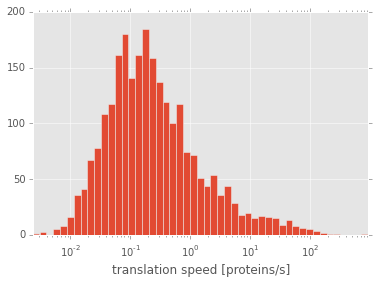

In [90]:
plt.hist(prot_speeds.values(), bins = 10**np.linspace(np.log10(min(prot_speeds.values())+0.0001), 
                                                              np.log10(max(prot_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(prot_speeds.values())+0.0001, max(prot_speeds.values())])
plt.gca().set_xlabel('translation speed [proteins/s]')
plt.show()

In [91]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

In [92]:
peptide_speeds = {prot: prot_speeds[prot] * len(orf_genomic_dict[prot]) / 3.0 for prot in prot_speeds}

In [93]:
pd.Series(peptide_speeds.values()).describe()

count      2496.000000
mean       1075.225360
std       11443.080245
min           1.517514
25%          26.236008
50%          67.382874
75%         233.406781
max      515968.230509
dtype: float64

Distribution of speeds of peptide bond creation (peptide bonds per second, every protein is one datapoint):

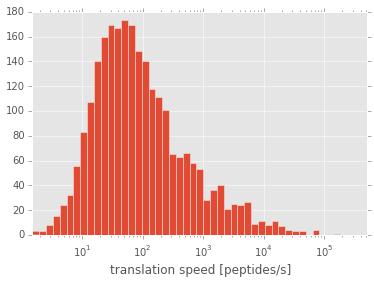

In [94]:
plt.hist(peptide_speeds.values(), bins = 10**np.linspace(np.log10(min(peptide_speeds.values())+0.0001), 
                                                              np.log10(max(peptide_speeds.values())), 50))
plt.gca().set_xscale("log")
plt.gca().set_xlim([min(peptide_speeds.values())+0.0001, max(peptide_speeds.values())])
plt.gca().set_xlabel('translation speed [peptides/s]')
plt.show()

Scatter plot speed, initiation rate and transcript abundance:

In [98]:
init_rates_plotkin = pkl.load(open('../parameters/init_rates_plotkin.p'))
init_rates_plotkin_old = pkl.load(open('../parameters/init_rates_plotkin_old.p'))
print len(init_rates_plotkin)
print len(init_rates_plotkin_old)

2569
5151


In [99]:
transcriptome_plotkin = pkl.load(open('../parameters/transcriptome_plotkin.p'))
print len(transcriptome_plotkin)
print sum(transcriptome_plotkin.values())

4839
60000


In [100]:
df1 = pd.DataFrame.from_dict(peptide_speeds.items())
df1.columns = ['name', 'peptide_speeds']

df2 = pd.DataFrame.from_dict(init_rates_plotkin.items())
df2.columns = ['name', 'init_rates_plotkin']

df3 = pd.DataFrame.from_dict(transcriptome_plotkin.items())
df3.columns = ['name', 'transcriptome_plotkin']

In [102]:
df = pd.merge(df1, df2, left_on='name', right_on='name', how='outer')
df = pd.merge(df, df3, left_on='name', right_on='name', how='outer')
df[:20]

,name,peptide_speeds,init_rates_plotkin,transcriptome_plotkin
0,YBR177C,161.141275,0.000002,8
1,YIL140W,125.698466,0.000001,5
2,YLR268W,96.203390,0.000002,10
3,YLR197W,4203.483051,0.000011,40
4,YAL008W,12.704879,0.000001,2
5,YOR043W,48.151078,0.000001,8
6,YJL122W,70.698305,0.000001,12
7,YNL300W,238.361536,0.000014,10
8,YLR244C,754.517514,0.000005,18
9,YPL144W,18.014689,0.000001,7


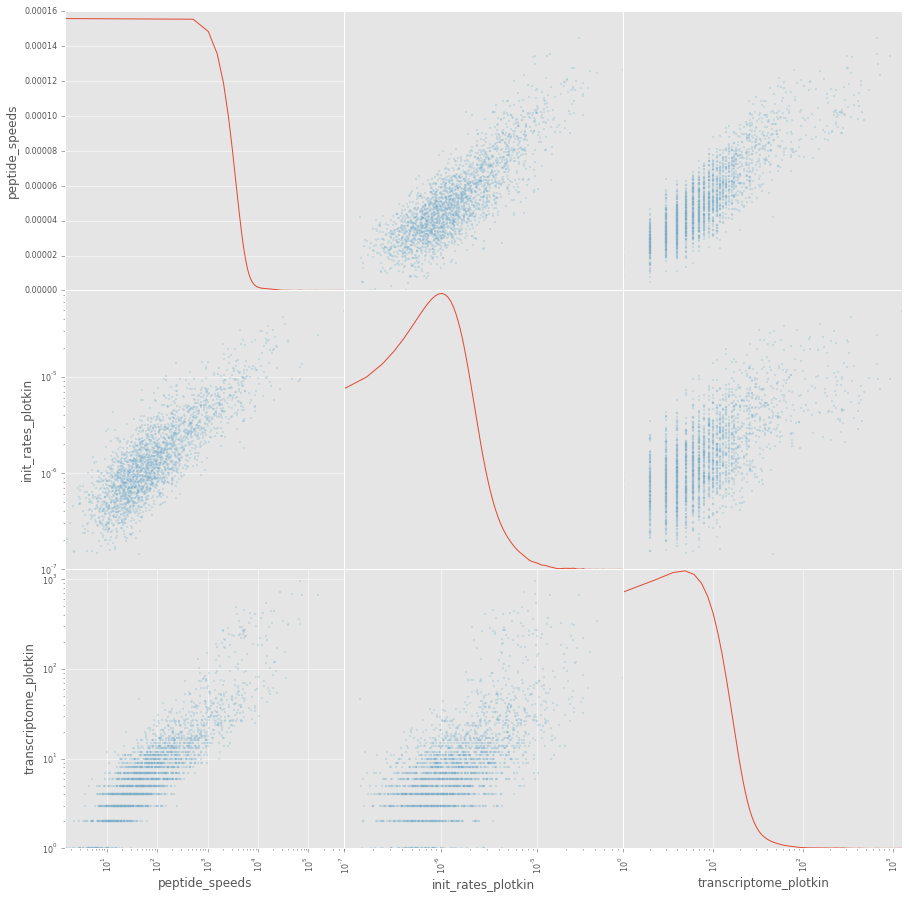

In [103]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0000001, df[df.columns[i+1]].min())
        minj = max(0.0000001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')         

Best predictor of peptide translation speed appears to be initiation rate but also transcript abundance has some effect.

### 2. Ribosome speed

We read a results dictionary which contains tic/toc results for the mRNAs:

In [104]:
filepath = "../results/full transcriptome and exome, no decay, specific best estimate initiation rates according to Plotkin_20150924_1940_1800s.p"

Function to replace `_numpypy.multiarray` by `numpy.core.multiarray`. Source: http://stackoverflow.com/questions/39086/search-and-replace-a-line-in-a-file-in-python

In [ ]:
replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")

In [28]:
results = pkl.load(open(filepath))

The following is smaller than 20000 (or 60000), probably because not for every gene in `transcriptome_plotkin_20000.p` there is an initiation rate available.

In [105]:
len(results['transcriptome'])

50243

In [124]:
transcript_tic_toc = {transcript.index: transcript.tic_toc for transcript in results['transcriptome']}

In [125]:
transcript_tic_toc_averages = {index: np.mean([toc-tic for (tic, toc) in transcript_tic_toc[index]]) for index in transcript_tic_toc}

In [126]:
transcript_df = pd.DataFrame(transcript_tic_toc_averages.values(), index=transcript_tic_toc_averages.keys())

In [127]:
transcript_df = pd.DataFrame(pd.Series(transcript_tic_toc_averages))
transcript_df.columns = ['tic_toc']

In [128]:
temp_df = pd.DataFrame(pd.Series({transcript.index: transcript.geneID for transcript in results['transcriptome']}))
temp_df.columns = ['geneID']

In [129]:
transcript_df = pd.merge(transcript_df, temp_df, left_index=True, right_index=True, how='outer')

In [130]:
gene_tic_toc = transcript_df.groupby('geneID').mean().to_dict()['tic_toc']
gene_tic_toc_df = pd.DataFrame.from_dict(gene_tic_toc.items())
gene_tic_toc_df.columns = ['name', 'tic_toc']

In [131]:
orf_genomic_dict = pkl.load(open("../parameters/orf_coding.p"))
len(orf_genomic_dict)

5917

In [132]:
orf_lengths = {prot: len(orf_genomic_dict[prot]) for prot in orf_genomic_dict}

In [133]:
pd.Series(orf_lengths.values()).describe()

count     5917.000000
mean      1485.306236
std       1149.149051
min         51.000000
25%        711.000000
50%       1218.000000
75%       1887.000000
max      14733.000000
dtype: float64

In [134]:
df1 = pd.DataFrame.from_dict(orf_lengths.items())
df1.columns = ['name', 'orf_length']

In [135]:
df = pd.merge(gene_tic_toc_df, df1, left_on='name', right_on='name', how='outer')

Scatter plot of ORF lengths against ribosome runtimes:

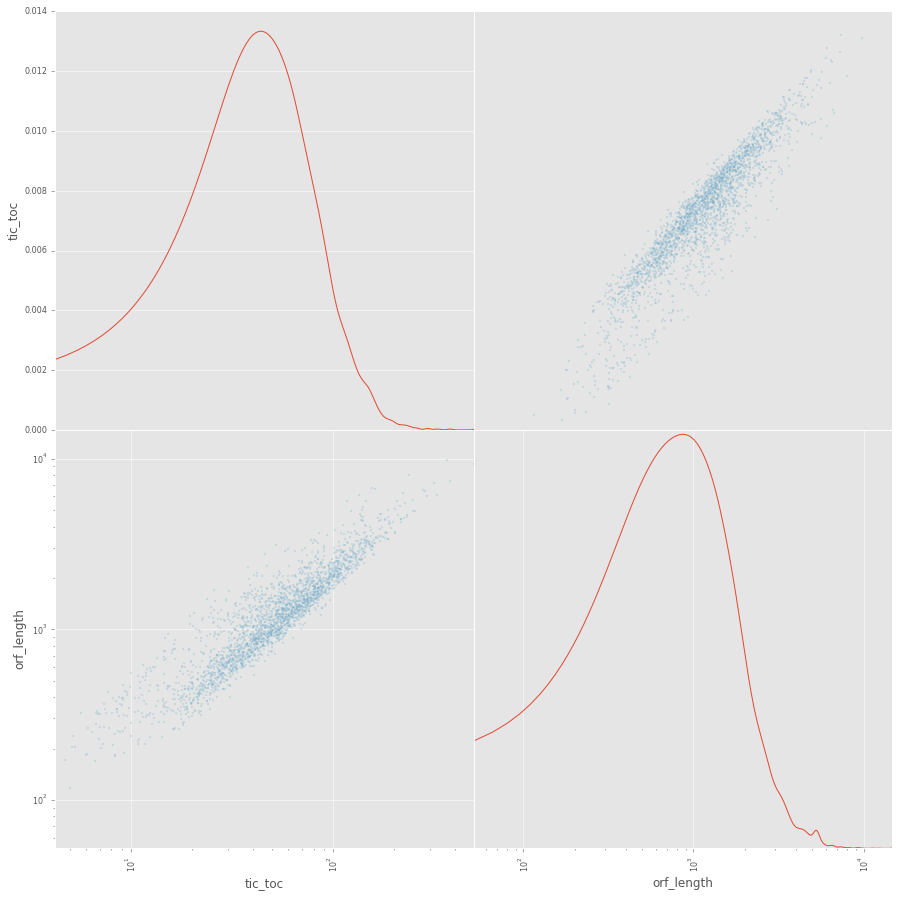

In [136]:
axl = pd.scatter_matrix(df, alpha=0.2, figsize=(15, 15), diagonal='kde')

for i, axs in enumerate(axl):
    for j, ax in enumerate(axs):
        mini = max(0.0001, df[df.columns[i+1]].min())
        minj = max(0.0001, df[df.columns[j+1]].min())
        if i != j:  # only the scatter plots
            # scale plot axes by their mins and maxs
            ax.set_xlim([minj+1, df[df.columns[j+1]].max()]) 
            ax.set_ylim([mini+1, df[df.columns[i+1]].max()])
            ax.set_xscale('log')
            ax.set_yscale('log')
        else:       # only the density plots
            ax.set_xlim([minj, df[df.columns[j+1]].max()])
            ax.set_xscale('log')            

In [137]:
ribo_inverse_speed_dict = {geneID: gene_tic_toc[geneID]/orf_lengths[geneID] for geneID in gene_tic_toc}

In [138]:
pd.Series(ribo_inverse_speed_dict.values()).describe()

count    2496.000000
mean        0.044789
std         0.010105
min         0.015241
25%         0.038885
50%         0.046469
75%         0.051659
max         0.076582
dtype: float64

Distribution of inverse ribosome speeds (seconds per nucleotide):

(array([   2.,    7.,    5.,    4.,   19.,   11.,   27.,   19.,   20.,
          23.,   20.,   25.,   21.,   26.,   26.,   27.,   40.,   41.,
          34.,   38.,   45.,   51.,   46.,   72.,   54.,   70.,   81.,
          92.,   89.,   92.,   89.,  132.,  110.,  121.,  106.,  145.,
         101.,   92.,   97.,   83.,   54.,   52.,   41.,   32.,   28.,
          11.,   11.,   18.,    7.,    8.,    8.,   11.,    2.,    2.,
           0.,    3.,    3.,    0.,    0.,    1.,    0.]),
 array([ 0.01524075,  0.01624075,  0.01724075,  0.01824075,  0.01924075,
         0.02024075,  0.02124075,  0.02224075,  0.02324075,  0.02424075,
         0.02524075,  0.02624075,  0.02724075,  0.02824075,  0.02924075,
         0.03024075,  0.03124075,  0.03224075,  0.03324075,  0.03424075,
         0.03524075,  0.03624075,  0.03724075,  0.03824075,  0.03924075,
         0.04024075,  0.04124075,  0.04224075,  0.04324075,  0.04424075,
         0.04524075,  0.04624075,  0.04724075,  0.04824075,  0.04924075,
    

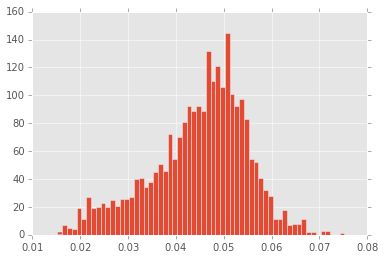

In [139]:
plt.hist(ribo_inverse_speed_dict.values(), bins=np.arange(min(ribo_inverse_speed_dict.values()), max(ribo_inverse_speed_dict.values()), 0.001))


In [140]:
ribo_speed_dict = {geneID: orf_lengths[geneID]/3.0/gene_tic_toc[geneID] for geneID in gene_tic_toc}

Translation speed distribution (codons per second):

(array([   9.,   54.,  139.,  338.,  450.,  373.,  263.,  184.,  139.,
          98.,   68.,   60.,   54.,   34.,   32.,   25.,   28.,   18.,
          20.,   16.,   16.,   16.,   16.,    7.,   13.,    8.,    1.,
           3.,    4.,    1.,    0.,    6.,    1.,    1.,    0.]),
 array([  4.35261236,   4.85261236,   5.35261236,   5.85261236,
          6.35261236,   6.85261236,   7.35261236,   7.85261236,
          8.35261236,   8.85261236,   9.35261236,   9.85261236,
         10.35261236,  10.85261236,  11.35261236,  11.85261236,
         12.35261236,  12.85261236,  13.35261236,  13.85261236,
         14.35261236,  14.85261236,  15.35261236,  15.85261236,
         16.35261236,  16.85261236,  17.35261236,  17.85261236,
         18.35261236,  18.85261236,  19.35261236,  19.85261236,
         20.35261236,  20.85261236,  21.35261236,  21.85261236]),
 <a list of 35 Patch objects>)

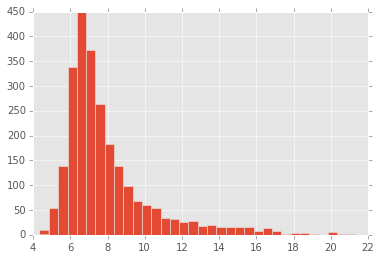

In [142]:
plt.hist(ribo_speed_dict.values(), bins=np.arange(min(ribo_speed_dict.values()), max(ribo_speed_dict.values()), 0.5))

Broadly in line with bionumbers: 1-10 codons per second

http://bionumbers.hms.harvard.edu/search.aspx?log=y&task=searchbytrmorg&trm=ribosome+rate&time=2015%2f09%2f25+08%3a06%3a19.092

TODO: Check against CAI

### 3. Ribosome density

Definition of ribosome density: average number of ribosomes per codon

Can depend on:

a) time - zero at first, reaches steady state (not discussed further)

b) position - density might be high at 5' end if initation rate is higher than rate at which ribosomes are transported away from initiation site

In [176]:
import shelve

filepath = "../results/ribosome_timecourses_full transcriptome and exome, no decay, specific best estimate initiation rates according to Plotkin_20150924_1941.db"
d = shelve.open(filepath)

Populate a dictionary with ribosome "lattices":

In [201]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last to catch steady state
    # Select only every third element (the others are zero anyway):
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

To make the ribosomes into a data frame, all array have to have the same length:

In [202]:
max_codons = len(max(ribo_lattice_dict.values(), key=len))

for gene in ribo_lattice_dict:
    ribo_lattice_dict[gene] = np.append(ribo_lattice_dict[gene], [None] * (max_codons - len(ribo_lattice_dict[gene])))

In [203]:
ribo_lattice_df = pd.DataFrame.from_dict(ribo_lattice_dict)
ribo_lattice_df[:15]

,YAL001C,YAL003W,YAL007C,YAL008W,YAL012W,YAL016W,YAL022C,YAL023C,YAL025C,YAL029C,YAL033W,YAL035W,YAL036C,YAL038W,YAL042W,YAL044C,YAL046C,YAL059W,YAL060W,YAR002W,
0,0,12,0,0,2,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,...
1,0,6,0,0,0,0,0,0,0,0,0,1,0,8,0,0,0,0,0,0,...
2,0,4,0,0,2,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,...
3,0,6,0,0,1,0,0,1,0,0,0,0,0,21,0,0,0,0,0,0,...
4,0,6,0,0,2,0,0,0,0,0,0,2,0,7,1,0,0,0,0,0,...
5,0,3,0,0,2,0,0,0,0,0,0,1,0,12,0,0,0,0,0,0,...
6,0,4,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,...
7,0,2,0,0,1,0,0,0,0,0,0,0,0,25,0,0,0,0,0,1,...
8,0,0,0,0,1,0,0,0,0,0,0,0,0,37,0,0,0,0,0,0,...
9,0,3,0,0,1,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,...


Check number of ribosomes in this data frame:

In [204]:
sum(dict(ribo_lattice_df.sum()).values())

176805.0

It is more convenient to remove the None values from `ribo_lattice_dict`:

In [205]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last to catch steady state
    # Select only every third element (the others are zero anyway):
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

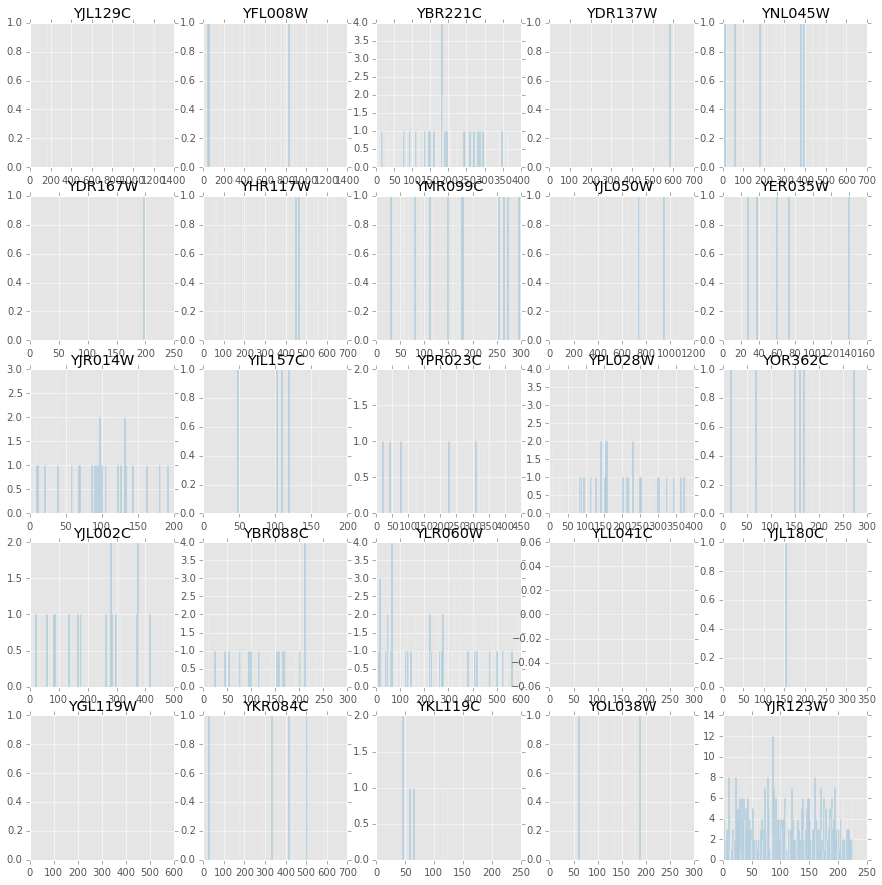

In [206]:
size = 5
genenames_plot = np.array(random.sample(ribo_lattice_dict.keys(), size*size))
genenames_plot.shape = (size, size)

fig, ax = plt.subplots(size, size, figsize=(15, 15))
for i in range(size):
    for j in range(size):
        plotlist = [elem for elem in ribo_lattice_dict[genenames_plot[i][j]]]
        ax[i, j].bar(range(len(plotlist)), plotlist)
        ax[i, j].set_title(genenames_plot[i][j])   


Average ribosome number per gene (average along the mRNA, across all codons):

In [207]:
average_ribos_per_gene = dict(ribo_lattice_df.mean(numeric_only=None))

Function to plot two dictionaries by their values:

In [208]:
def scatter_dicts(dict1, dict2, xaxislabel=None, yaxislabel=None):
    plotkeys = dict1.viewkeys() & dict2.viewkeys() # set intersection
    print len(plotkeys)
    xs = [dict1[key] for key in plotkeys]
    ys = [dict2[key] for key in plotkeys] 

    fig =  plt.figure()                

    ax = fig.add_subplot(111)
    ax.grid(True, linestyle = '-', color = '0.75')
    ax.set_xscale('log')
    ax.set_yscale('log')
    if xaxislabel:
        ax.set_xlabel(xaxislabel)
    if yaxislabel:
        ax.set_ylabel(yaxislabel)

    scat = plt.scatter(xs, ys)
    scat.set_alpha(0.2)

    points = zip(xs, ys)
    sorted_points = sorted(points)
    new_xs = [point[0] for point in sorted_points]
    new_ys = [point[1] for point in sorted_points]
    ylowess = lowess(new_ys, new_xs)[:,1]
    plt.plot(new_xs, ylowess, 'orange', linewidth=4)

    plt.show()

Scatter plot against ORF lengths (mostly to rule out a mistake with the different lengths):

2405


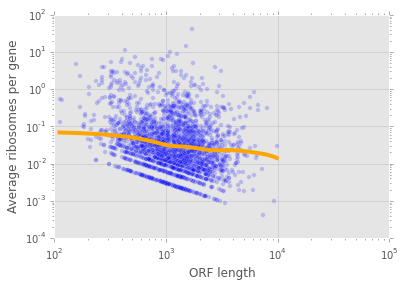

In [209]:
scatter_dicts(orf_lengths, {gene: average_ribos_per_gene[gene] for gene in average_ribos_per_gene 
                                if average_ribos_per_gene[gene] > 1e-16}, 'ORF length', 'Average ribosomes per gene')

No recognizable correlation - probably correct!

This means dividing by the length takes care of the correlation.

Normalize by transcript abundance:

In [210]:
transcriptome = pkl.load(open("../parameters/transcriptome_plotkin.p", "rb"))
init_rates = pkl.load(open("../parameters/init_rates_plotkin.p", "rb"))

In [211]:
print len(transcriptome)
print sum(transcriptome.values())

4839
60000


In [212]:
average_ribos_per_transcript = {gene: np.mean(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene]))                                
                                for gene in ribo_lattice_df
                                if np.mean(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene])) > 1e-16}

In [213]:
total_ribos_per_transcript = {gene: sum(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene]))                                
                                for gene in ribo_lattice_df
                                if sum(np.array([ribos for ribos in ribo_lattice_df[gene] 
                                if ribos is not None])/float(transcriptome[gene])) > 1e-16}

Plot against ORF length:

2405


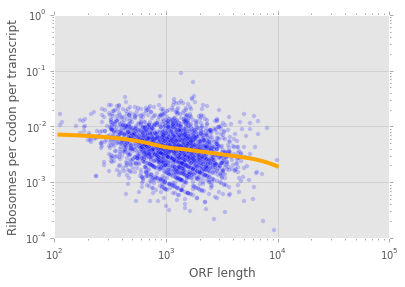

In [215]:
scatter_dicts(orf_lengths, average_ribos_per_transcript, 'ORF length', 'Ribosomes per codon per transcript')

2405


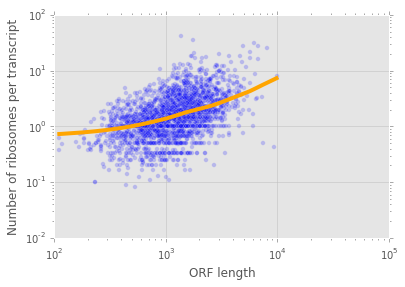

In [216]:
scatter_dicts(orf_lengths, total_ribos_per_transcript, 'ORF length', 'Number of ribosomes per transcript')

This is a relatively weak dependence because shorter genes have higher initiation rates which counteracts the (trivial) length effect.

Plot against initiation rate:

2405


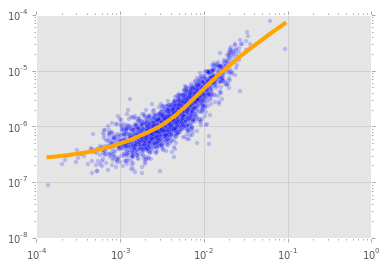

In [217]:
scatter_dicts(average_ribos_per_transcript, init_rates)

TODO: what explains the remaining dispersion? TODO: check CAI?

Analysis by codon position:

In [218]:
ribo_lattice_df_normalized = pd.DataFrame()

for column in ribo_lattice_df:
    ribo_lattice_df_normalized[column] = ribo_lattice_df[column]/float(transcriptome[column])

In [220]:
means_per_position = ribo_lattice_df_normalized.mean(axis=1, numeric_only=None)
means_per_position

0     0.005995
1     0.006194
2     0.005884
3     0.005403
4     0.005501
5     0.005610
6     0.005420
7     0.004842
8     0.005441
9     0.005792
10    0.006616
11    0.005531
12    0.004903
13    0.005637
14    0.006129
...
3254    0
3255    0
3256    0
3257    0
3258    0
3259    0
3260    0
3261    0
3262    0
3263    0
3264    0
3265    0
3266    0
3267    0
3268    0
Length: 3269, dtype: float64

In [221]:
positions = len(means_per_position)
# not all genes in the transcriptome have an orf_length, why?
transcripts_per_position = [sum([transcriptome[gene] for gene in transcriptome 
                            if gene in orf_lengths and position+1 <= orf_lengths[gene]/3])
                            for position in range(positions)]
len(transcripts_per_position)

3269

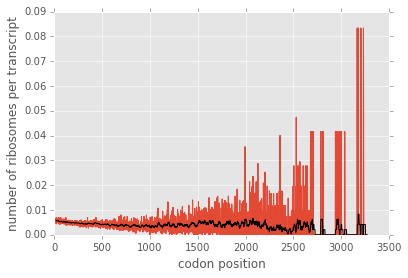

In [222]:
ts = means_per_position
ts.plot(style='r').set_xlabel('codon position')
ts.plot().set_ylabel('number of ribosomes per transcript')
#plt.xlim([0, 500])
#plt.ylim([0, 0.01])
#plt.yscale('log') 
pd.rolling_mean(ts, 20).plot(style='k')

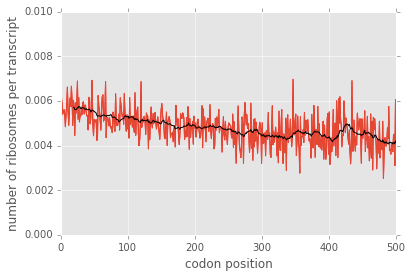

In [223]:
ts = means_per_position
ts.plot(style='r').set_xlabel('codon position')
ts.plot().set_ylabel('number of ribosomes per transcript')
plt.xlim([0, 500])
plt.ylim([0, 0.01])
pd.rolling_mean(ts, 20).plot(style='k')

Let us try on single genes:

Find gene with maximum transcription (for best statistics):

In [224]:
maxgene = max(transcriptome.iterkeys(), key=(lambda key: transcriptome[key]))
maxgene, transcriptome[maxgene]

('YLR044C', 1283)

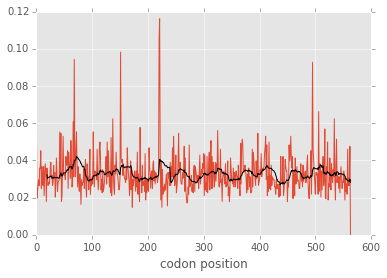

In [227]:
ribo_lattice_df_normalized[maxgene].plot().set_xlabel('codon position')
pd.rolling_mean(ribo_lattice_df_normalized[maxgene], 20).plot(style='k')

No ribosome ramp at individual gene level? This would be consistent with Shah's hypothesis that it is caused by short genes with high initiation probabilities. 

TODO: we need to check this more systematically.

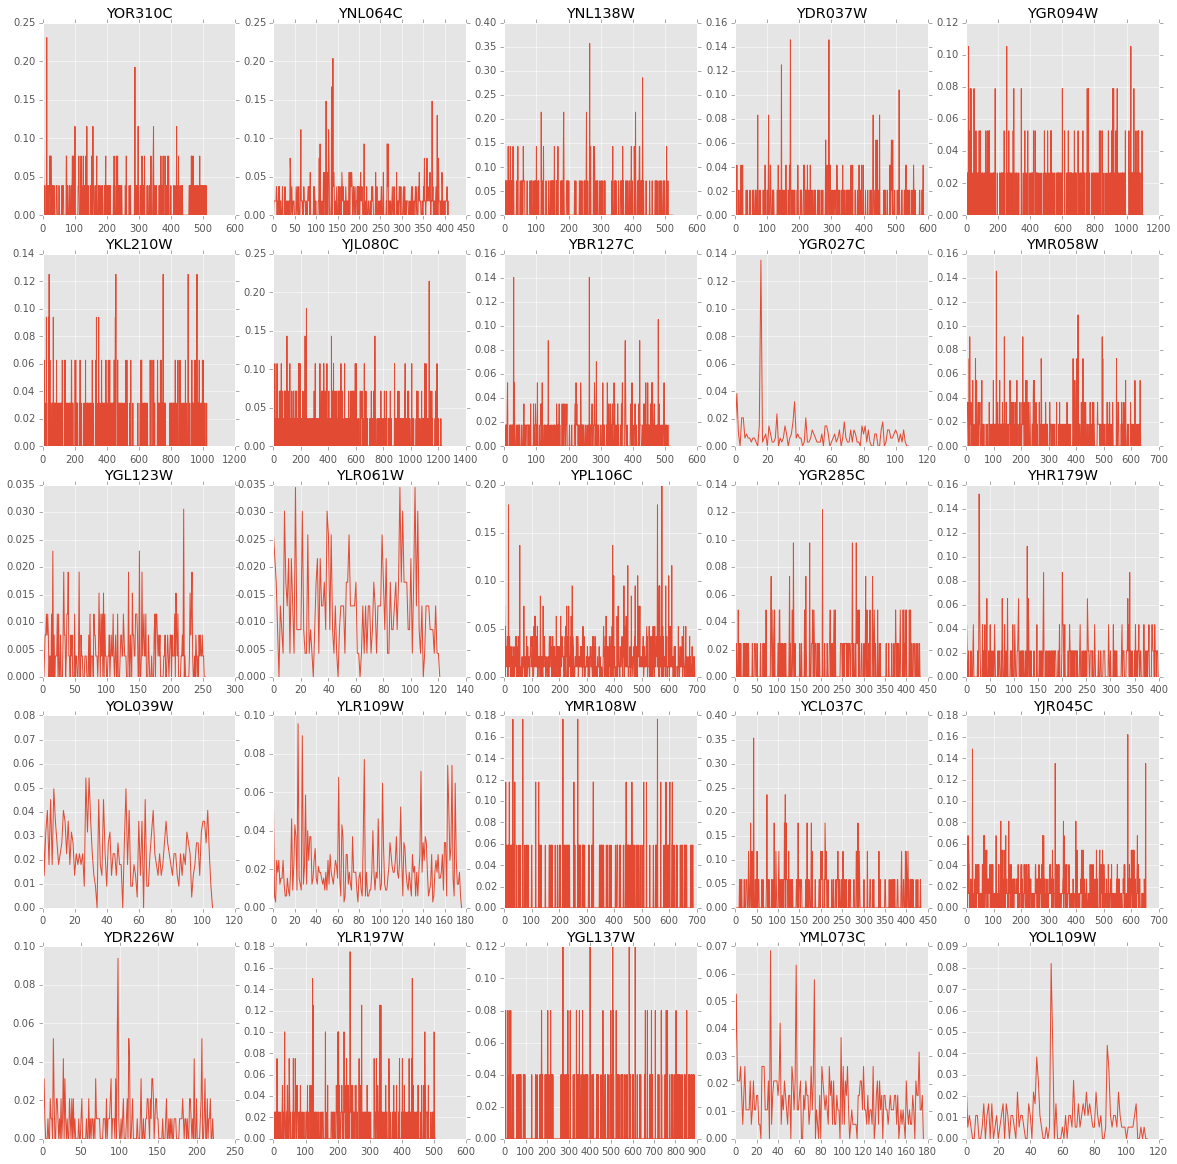

In [272]:
high_transcript_abundance_genes = [gene for gene in ribo_lattice_dict 
                                   if sum([elem for elem in ribo_lattice_dict[gene]]) > 150]

size = 5
genenames_plot = np.array(random.sample(high_transcript_abundance_genes, size*size))
genenames_plot.shape = (size, size)

fig, ax = plt.subplots(size, size, figsize=(20, 20))
for i in range(size):
    for j in range(size):
        plotlist = [elem for elem in ribo_lattice_dict[genenames_plot[i][j]] if elem is not None]
        ax[i, j].plot(ribo_lattice_df_normalized[genenames_plot[i][j]])
        #ax[i, j].set_xlabel('codon position')
        ax[i, j].set_title(genenames_plot[i][j])   


To calculate the SNR, we establish standard deviations and maxima of the ribosome densities:

In [233]:
sigmas = {gene: np.std(ribo_lattice_df_normalized[gene]) for gene in ribo_lattice_dict}

Find all peaks where the signal to noise ratio is greater than a predefined threoshold:

In [278]:
threshold = 5

peaks = {gene: [(pos, value, value / sigmas[gene]) for (pos, value) in enumerate(ribo_lattice_df_normalized[gene]) 
                if value / sigmas[gene] > threshold] 
         for gene in sigmas if sigmas[gene] != 0
        and gene in high_transcript_abundance_genes}  # delete this to include all genes

In [282]:
peaks['YOL109W']

[(53, 0.08196721311475409, 7.2416032610555812)]

Codons at peaks (hypothesis is that these might be rare codons):

In [302]:
from translation.TRSL_specific import codon_anticodon, tRNA_types

In [296]:
codons_at_peaks = {gene: [orf_genomic_dict[gene][elem[0]*3:elem[0]*3+3] for elem in peaks[gene]] for gene in peaks}

In [313]:
anticodons_at_peaks = {gene: [codon_anticodon[codon] for codon in codons_at_peaks[gene]]
                       for gene in codons_at_peaks}

In [314]:
anticodons_at_peaks

{'YAL003W': [],
 'YAL012W': ['gag', 'gag', 'gag', 'gag'],
 'YAL035W': ['gag', 'gag', 'ccu'],
 'YAL038W': ['uga',
  'gca',
  'cau',
  'gca',
  'gca',
  'gca',
  'gca',
  'gca',
  'gca',
  'agg'],
 'YBL076C': ['gag', 'gag', 'gag', 'ccu'],
 'YBL092W': ['agg', 'uga'],
 'YBL099W': ['gag', 'agg', 'gag', 'gag', 'gag'],
 'YBR011C': ['agg', 'uac', 'cuc', 'cuc', 'ccu'],
 'YBR025C': ['gca', 'cuc', 'cgu', 'uag'],
 'YBR078W': ['gcu', 'gag'],
 'YBR079C': ['gag', 'gag', 'gug', 'cuc', 'cug'],
 'YBR127C': ['cgu', 'gag', 'gag'],
 'YBR189W': [],
 'YBR196C': ['uag', 'uag', 'cuc', 'cga', 'gcu', 'cga'],
 'YBR286W': ['cug', 'gag', 'gag', 'gag', 'gag', 'cac'],
 'YCL009C': [],
 'YCL037C': ['gag', 'cga', 'cga'],
 'YCL043C': ['gag', 'cuc', 'gag'],
 'YCR012W': ['uga', 'uga', 'gca', 'gcu', 'cuc', 'ucc', 'gcu'],
 'YCR053W': ['gag', 'gag', 'cug', 'gag'],
 'YDL055C': ['gag', 'gag'],
 'YDL066W': ['cga'],
 'YDL075W': ['uag'],
 'YDL081C': [],
 'YDL095W': ['gag', 'uag', 'gag', 'cga', 'agg', 'gag', 'gag', 'gag', 'cuc'],
 

Define auxiliary function:

In [321]:
from itertools import chain

def flatten_dict_values(dictionary):
    return list(chain(*dictionary.values()))

In [326]:
from collections import Counter

counter = Counter(flatten_dict_values(anticodons_at_peaks))

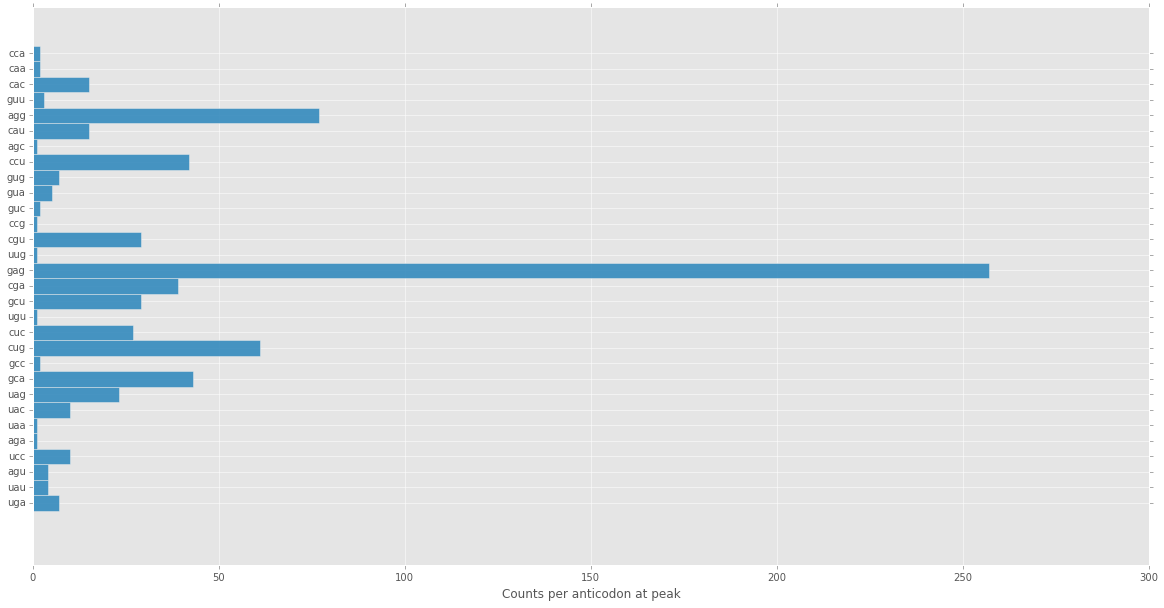

In [360]:
keys = counter.keys()
y_pos = np.arange(len(keys))*5

# get the counts for each key, assuming the values are numerical
counts = counter.values()

plt.figure(figsize=(20,10))
plt.barh(y_pos, counts, align='center', height=5, alpha=0.9)
plt.yticks(y_pos, keys)
plt.xlabel('Counts per anticodon at peak')

plt.show()

In [340]:
y_pos = np.arange(len(keys))*2
y_pos

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58])

### 4. Number of free ribosomes

In [ ]:
results["timecourses"]["ribos._free"]

Time course plots would be interesting... (oscillation!)